In [644]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import tf_keras as keras # need keras 2 to fit Lattice model
from tf_keras.models import Sequential, Model
from tf_keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from tf_keras.constraints import Constraint
from tf_keras.callbacks import EarlyStopping
from tf_keras.initializers import Zeros, Constant
from tf_keras.optimizers import Adam, Nadam, RMSprop
from tf_keras.models import clone_model
import keras_tuner as kt
from tf_keras import backend as K
from tf_keras import regularizers
from tf_keras.utils import plot_model
from tf_keras.losses import Poisson, Loss
from tf_keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [645]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [646]:
#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_low_var.csv")

In [647]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,134.591148
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,598.510048
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,618.601250
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,54.444712
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,53.958957
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,0,-0.906239,0.044427,4,0.539039,0.823778,0.218616,112.214708
19996,-0.403467,0.989823,-0.239838,0,-0.264332,-0.555279,1,-0.841188,-0.964766,-0.498512,240.796882
19997,-0.107088,0.176448,-0.661992,0,0.900670,0.995538,2,0.667651,-0.428700,0.324157,1064.679359
19998,-0.279747,-0.150770,-0.472139,1,0.639225,0.127594,3,0.545812,0.189384,-0.602032,809.013432


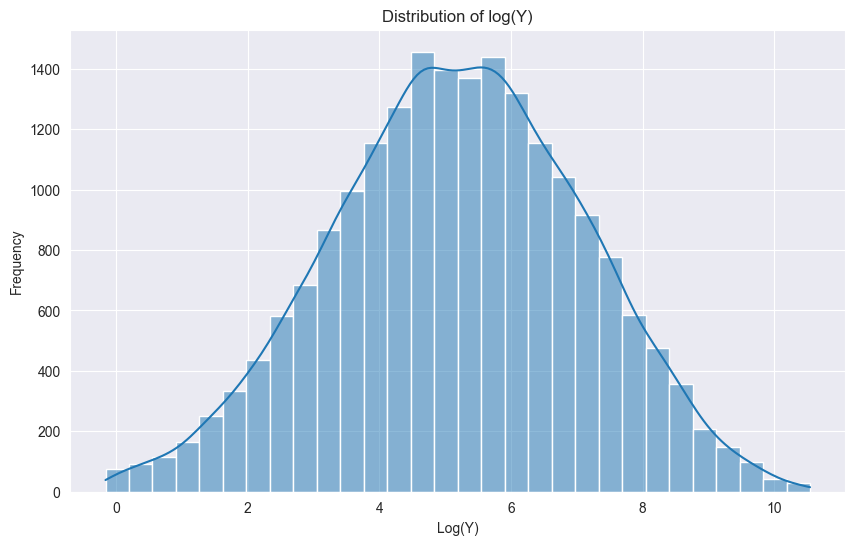

In [648]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [649]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_cleaned.columns)
all_vars.remove(target_var) # store all input features
cat_vars = ["X4", "X7"] # categorical features

In [650]:
############################ 1. MODEL FITTING ############################

#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[all_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [651]:
# -------------------------- function to create a subnetwork --------------------------
# Layer to center a subnetwork's outputs to zero mean
@keras.saving.register_keras_serializable()
class ZeroCenter(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        mean = K.mean(inputs, axis = 0, keepdims = True)
        return inputs - mean

# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(ZeroCenter()) # zero center all output
    return model

# layer to add all subnets' outputs and a bias term
@keras.saving.register_keras_serializable()
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape=(1,), initializer = 'zeros', trainable = True, name = 'bias'
        )
    
    def call(self, inputs):
        subnet_sum = K.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

In [652]:
# -------------------------- define model architecture --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 10
num_layers_main = 2
activation = 'leaky_relu'
keypoints = 10
monotonicity_list = {"X1" : "decreasing"} # either "increasing", "decreasing", or "none"
# lattice_smooth_reg = (0,0) # L1-L2 regularization for smoothness constraint

# main effect
for name in all_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        mean_layer = ZeroCenter(name = f"{name}_mean")(embed_layer_reshape)
        switcher_layer = Dense(1, use_bias = False, 
                                kernel_initializer = Constant(1),
                                trainable = False, 
                                name = f"{name}_switcher_layer")(mean_layer)
        sub_outputs_main.append(switcher_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
            # kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        mean_layer = ZeroCenter(name = f"{name}_mean")(calibrator_layer)
        switcher_layer = Dense(1, use_bias = False, 
                        kernel_initializer = Constant(1),
                        trainable = False, 
                        name = f"{name}_switcher_layer")(mean_layer)
        sub_outputs_main.append(switcher_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        switcher_layer = Dense(1, use_bias = False, 
                                kernel_initializer = Constant(1),
                                trainable = False, 
                                name = f"{name}_switcher_layer")(sub_output)
        sub_outputs_main.append(switcher_layer)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
final_output = AddSubnetOutput(activation = 'exponential',
                     name = "main_output")(main_subnets)

# final model
model_main_effect = Model(inputs = inputs, outputs = final_output)

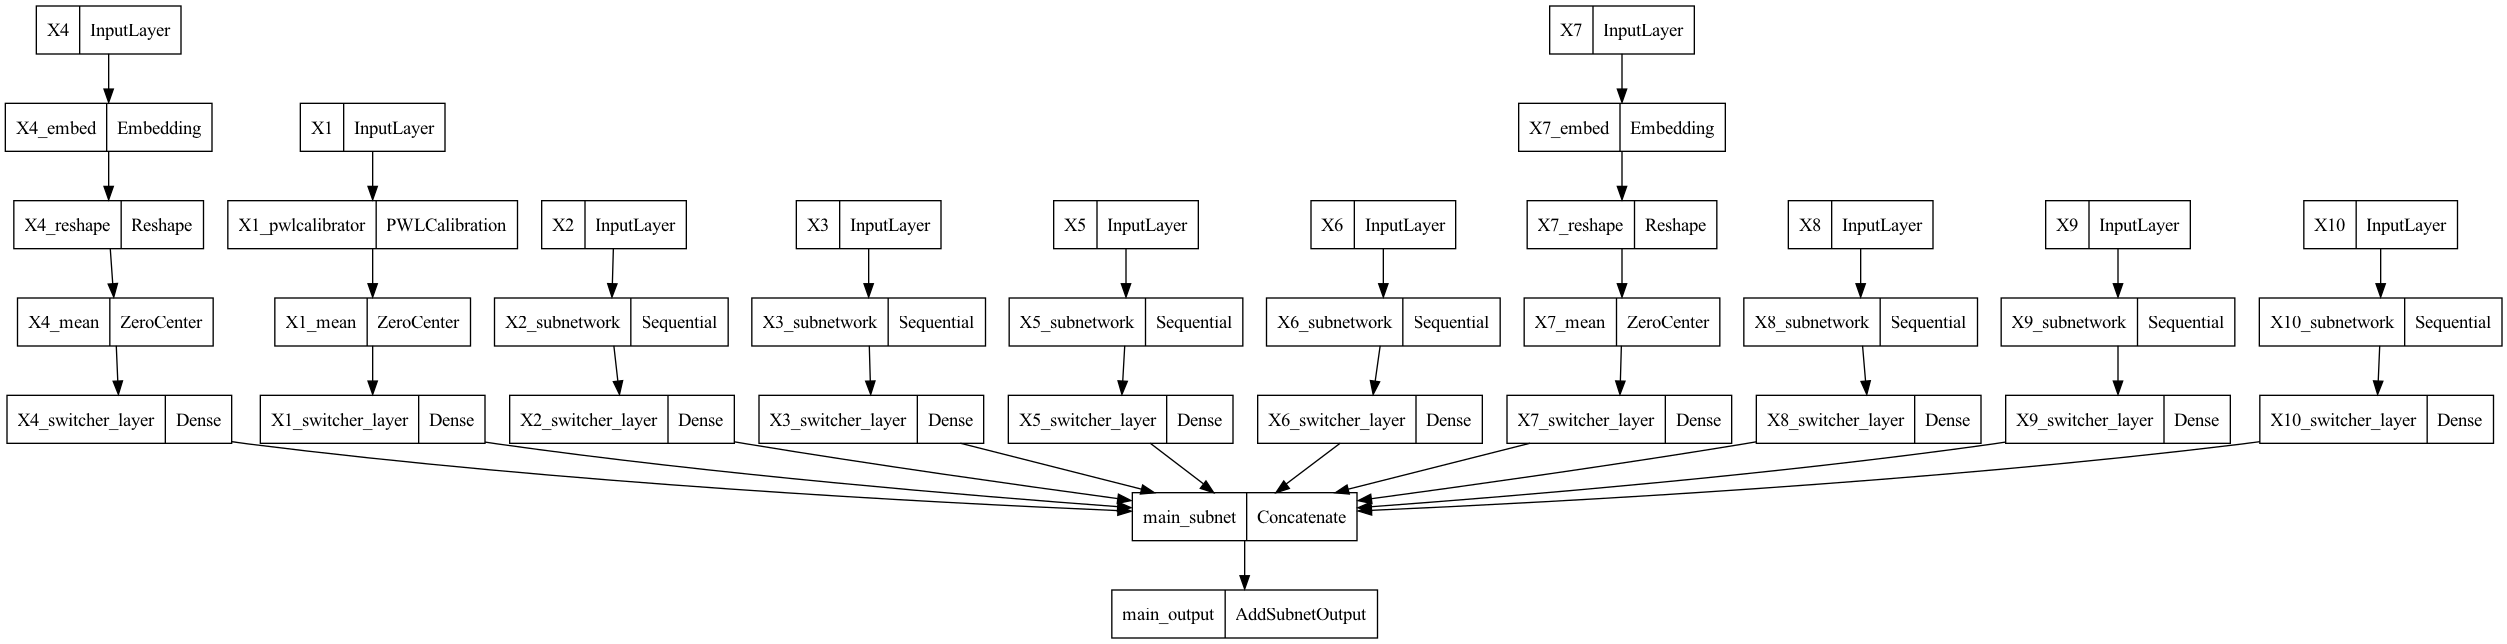

In [653]:
plot_model(model_main_effect)

In [654]:
# -------------------------- define loss function --------------------------
# we will use a Gamma loss function
def gamma_log_likelihood(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-7, 1e30)
    return K.mean(y_true/y_pred - K.log(y_true/y_pred))

# create training & validation data consistent with the model architecture
X_train_split = []
X_val_split = []
X_test_split = []
for i in range(len(X_train.columns)):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])
    X_test_split.append(X_test.iloc[:, i])

# compile and fit
model_main_effect.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))

Epoch 1/5000


12/12 [==============================] - 1s 21ms/step - loss: 903.3867 - root_mean_squared_error: 2636.8281 - val_loss: 887.6082 - val_root_mean_squared_error: 2536.0615
Epoch 2/5000
12/12 [==============================] - 0s 4ms/step - loss: 845.8120 - root_mean_squared_error: 2636.8140 - val_loss: 840.8905 - val_root_mean_squared_error: 2536.0457
Epoch 3/5000
12/12 [==============================] - 0s 4ms/step - loss: 808.6760 - root_mean_squared_error: 2636.7996 - val_loss: 806.5901 - val_root_mean_squared_error: 2536.0295
Epoch 4/5000
12/12 [==============================] - 0s 4ms/step - loss: 779.0103 - root_mean_squared_error: 2636.7859 - val_loss: 776.7510 - val_root_mean_squared_error: 2536.0117
Epoch 5/5000
12/12 [==============================] - 0s 4ms/step - loss: 751.0492 - root_mean_squared_error: 2636.7681 - val_loss: 749.4904 - val_root_mean_squared_error: 2535.9934
Epoch 6/5000
12/12 [==============================] - 0s 4ms/step - loss: 726.1469 - root_mean_squared

In [655]:
# -------------------------- get validation loss --------------------------
main_val_loss, main_rmse = model_main_effect.evaluate(X_val_split, y_val, verbose = False, batch_size = X_val_split[0].shape[0]) # get the validation loss and RMSE
print(f"Validation loss for main effect: {main_val_loss}")
print(f"Validation RMSE for main effect: {main_rmse}")

Validation loss for main effect: 2.10115909576416
Validation RMSE for main effect: 2184.6748046875


1/1 [==============================] - 0s 131ms/step


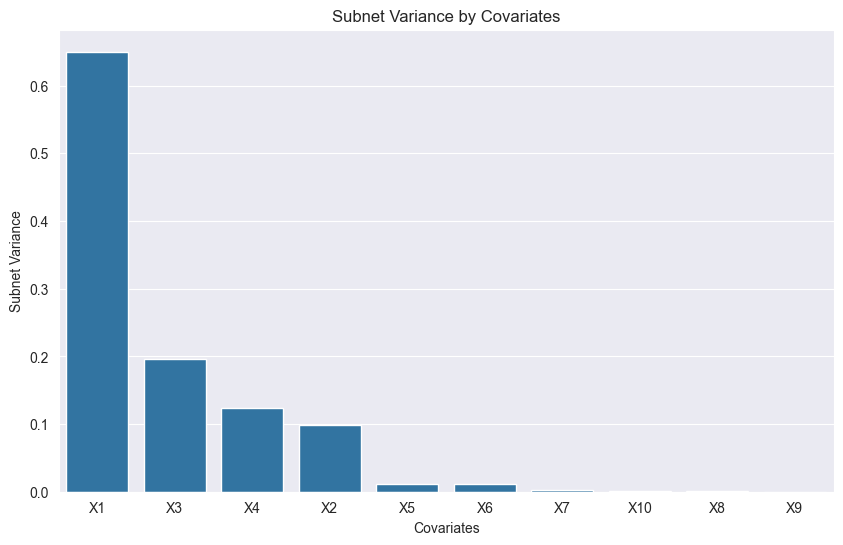

In [656]:
# -------------------------- quantify variable importance --------------------------
main_output_layer = model_main_effect.get_layer("main_subnet")  # Get the subnet output layer
main_model = Model(inputs = model_main_effect.inputs, outputs = main_output_layer.output)
main_output_values = main_model.predict(X_train_split, batch_size = X_train_split[0].shape[0])
# subnet_weights = model_main_effect.get_layer("main_output").get_weights()[0]


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(main_output_values.shape[1]):
    subnet_variance.append(np.var(main_output_values[:, i]))

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

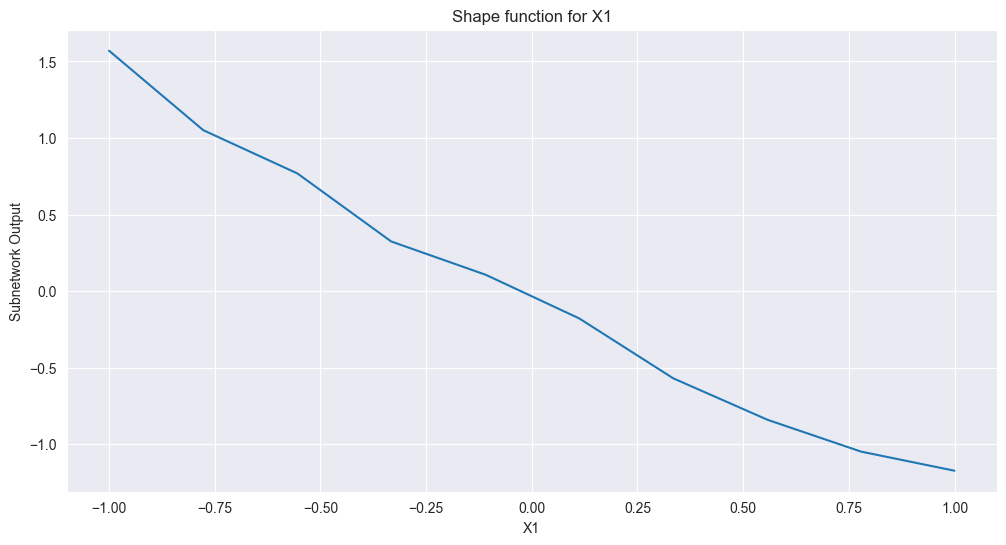

In [657]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X1"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_split[var_index], 
             y = main_output_values[:,var_index].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [658]:
############################   preparation for interaction selection   ############################
global_layers = ["main_subnet", "main_output", "interaction_output", "final_output"] # these layers are always trainable
interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
imp_vars = [f"X{i}" for i in range(1,7)] # important variables
interactions = combinations(imp_vars, 2)
num_layers_interaction = 3 # number of layers for each interaction effect
num_neurons_interaction = 30 # number of neurons per dense layer for each interaction effect
lattice_sizes_pairwise = {}
for var in imp_vars:
    if var in cat_vars:
        lattice_sizes_pairwise[var] = X_train[var].nunique()
    else:
        lattice_sizes_pairwise[var] = 2

In [659]:
############################   select interaction effect   ############################

# add pairwise effect and evaluate validation loss
for var1, var2 in interactions:

    # -------------------------- initialize a cloned model --------------------------
    model_main_cloned = clone_model(model_main_effect) # clone the main effect model
    model_main_cloned.build(model_main_effect.input_shape)
    model_main_cloned.set_weights(model_main_effect.get_weights()) # copy the weights

    # -------------------------- build a subnet for pairwise interaction effect --------------------------
    var1_input = model_main_cloned.inputs[all_vars.index(var1)]
    var2_input = model_main_cloned.inputs[all_vars.index(var2)]

    # Lattice model if the pair contains a monotonic variable
    if any(var in monotonicity_list for var in [var1, var2]):
        lattice_inputs = []

        # var1
        if var1 in cat_vars:
            var1_calibrator = tfl.layers.CategoricalCalibration(
                num_buckets = X_train[var1].nunique(),
                output_min = 0,
                output_max = lattice_sizes_pairwise[var1] - 1,
                name = f"{var1}_calibrator_pairwise"
            )(var1_input)
        else:
            var1_calibrator = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[var1].min(), X_train[var1].max(), num = keypoints), # keypoints
                # kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
                monotonicity = monotonicity_list[var1] if var1 in monotonicity_list else "none", # monotonicity constraint
                output_min = 0,
                output_max = lattice_sizes_pairwise[var1] - 1,
                name = f"{var1}_calibrator_pairwise"
        )(var1_input)
        
        # var2
        if var2 in cat_vars:
            var2_calibrator = tfl.layers.CategoricalCalibration(
                num_buckets = X_train[var2].nunique(),
                output_min = 0,
                output_max = lattice_sizes_pairwise[var2] - 1,
                name = f"{var2}_calibrator_pairwise"
            )(var2_input)
        else:
            var2_calibrator = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[var2].min(), X_train[var2].max(), num = keypoints), # keypoints
                # kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
                monotonicity = monotonicity_list[var2] if var2 in monotonicity_list else "none", # monotonicity constraint
                output_min = 0,
                output_max = lattice_sizes_pairwise[var2] - 1,
                name = f"{var2}_calibrator_pairwise"
        )(var2_input)
        
        # lattice
        lattice_inputs.append(var1_calibrator)
        lattice_inputs.append(var2_calibrator)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_pairwise[var1],lattice_sizes_pairwise[var2]], 
                             monotonicities = ["increasing" if var1 in monotonicity_list else 'none',
                                                "increasing" if var2 in monotonicity_list else 'none'],
                            #  kernel_regularizer = tfl.pwl_calibration_layer.HessianRegularizer(
                            #     l1 = 0.01, l2 = 0),
                             name = f"{var1}_{var2}_lattice")(lattice_inputs)
        pairwise_output = ZeroCenter(name = f"{var1}_{var2}_mean")(lattice_layer)
    else:
    # Subnetwork if the pair contains no monotonic variables
        pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
        pairwise_subnet = create_subnet(num_layers_interaction, 
                                        num_neurons_interaction, 
                                        activation, 
                                        f"{var1}_{var2}_subnetwork")
        pairwise_output = pairwise_subnet(pairwise_input_layer)

    interaction_subnet_output = Activation('exponential',
                        name = "interaction_output")(pairwise_output)
    main_subnet_output = model_main_cloned.output
    final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
    model_pairwise = Model(inputs = model_main_cloned.inputs, outputs = final_output)

    # -------------------------- switch on/off layers --------------------------
    for layer in model_pairwise.layers:
        if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
            layer.trainable = False
    
    # -------------------------- compile and train the model --------------------------
    model_pairwise.compile(optimizer = 'rmsprop', loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
    es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    model_pairwise.fit(X_train_split, y_train, epochs = 5_000, \
                            callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))
    val_loss, _ = model_pairwise.evaluate(X_val_split, y_val, batch_size = X_val_split[0].shape[0])
    interaction_loss[f"{var1}_{var2}"] = val_loss # add to the val loss list

Epoch 1/5000
12/12 [==============================] - 1s 23ms/step - loss: 2.1313 - root_mean_squared_error: 2378.4517 - val_loss: 2.1102 - val_root_mean_squared_error: 2273.0332
Epoch 2/5000
12/12 [==============================] - 0s 4ms/step - loss: 2.1166 - root_mean_squared_error: 2339.6372 - val_loss: 2.1030 - val_root_mean_squared_error: 2232.7905
Epoch 3/5000
12/12 [==============================] - 0s 4ms/step - loss: 2.1088 - root_mean_squared_error: 2313.5244 - val_loss: 2.1007 - val_root_mean_squared_error: 2214.8823
Epoch 4/5000
12/12 [==============================] - 0s 4ms/step - loss: 2.1058 - root_mean_squared_error: 2302.3044 - val_loss: 2.0993 - val_root_mean_squared_error: 2198.7288
Epoch 5/5000
12/12 [==============================] - 0s 3ms/step - loss: 2.1015 - root_mean_squared_error: 2289.9346 - val_loss: 2.1005 - val_root_mean_squared_error: 2196.0828
Epoch 6/5000
12/12 [==============================] - 0s 3ms/step - loss: 2.1012 - root_mean_squared_error: 2

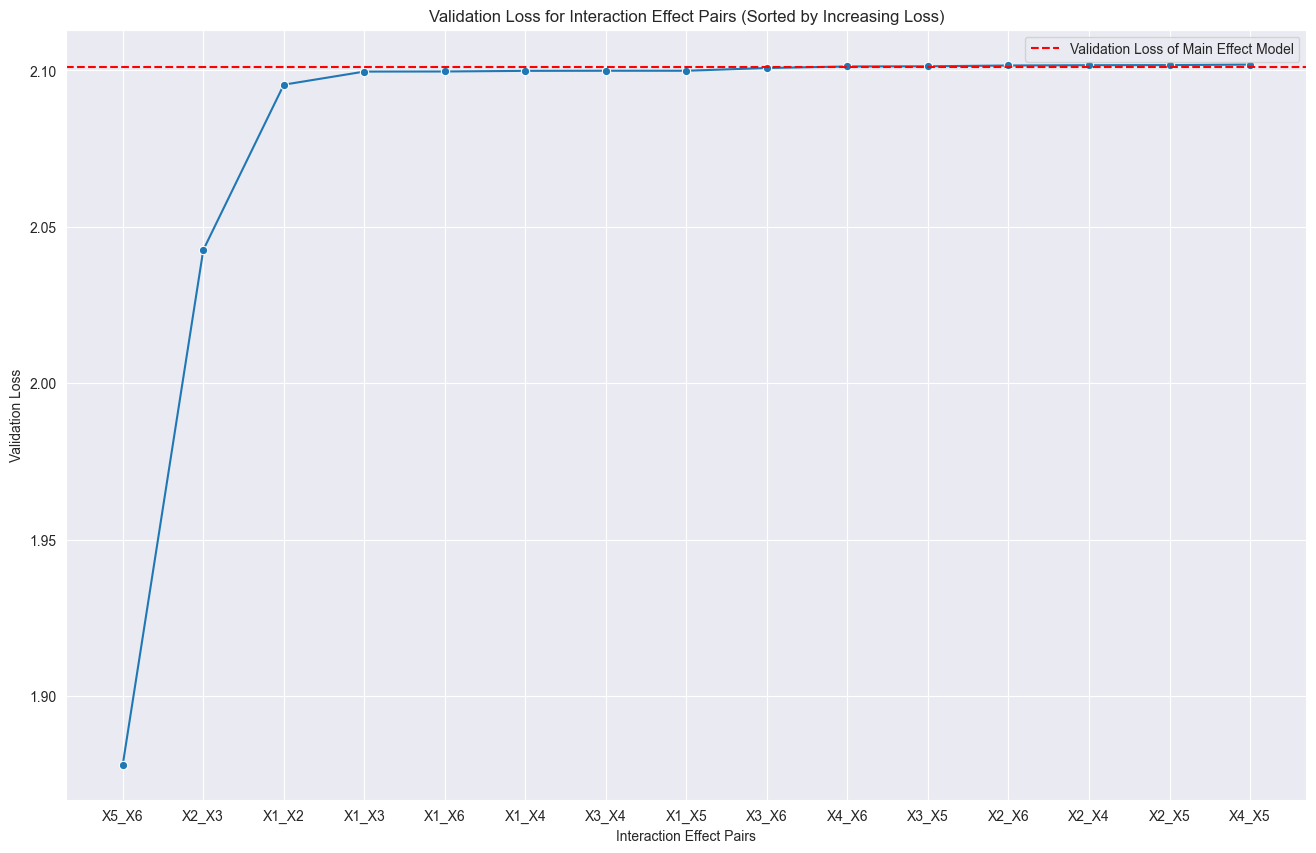

In [660]:
# -------------------------- plot the validation loss --------------------------
# Convert interaction loss dictionary to a pandas DataFrame
interaction_df = pd.DataFrame(list(interaction_loss.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

# Sort the DataFrame by Validation_Loss in increasing order
interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)

# Create the bar plot using Seaborn
plt.figure(figsize = (16, 10))
sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
plt.axhline(main_val_loss, color = 'red', linestyle = '--', label = 'Validation Loss of Main Effect Model')
plt.xlabel('Interaction Effect Pairs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Interaction Effect Pairs (Sorted by Increasing Loss)')
plt.legend()
plt.show()

In [668]:
# -------------------------- hyperparameters of final model --------------------------
imp_interactions = [("X5","X6"),("X2","X3"),("X1","X2")]
inputs = []  # input layers
sub_outputs = [] # subnet output
num_neurons_main = 40
num_layers_main = 5
num_neurons_interaction = 100
num_layers_interaction = 5
activation = 'leaky_relu'
lattice_smooth_reg = (0.01,0)
num_keypoints = 20
monotonicity_list = {"X1" : "decreasing"}
lattice_sizes_full = {}
for var in imp_vars:
    # for lattice size
    if var in cat_vars:
        lattice_sizes_full[var] = X_train[var].nunique()
    else:
        lattice_sizes_full[var] = 2

In [669]:
# -------------------------- model architecture --------------------------
# main effect
for name in imp_vars:
    
    # Input layers
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        cat_output = ZeroCenter(name = f"{name}_dense")(embed_layer_reshape)
        sub_outputs.append(cat_output)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = num_keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_calibrator"
        )(input_layer)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_full[name]], 
                             monotonicities = ["increasing"],
                             name = f"{name}_lattice")(calibrator_layer)
        mean_layer = ZeroCenter(name = f"{name}_mean")(lattice_layer)
        switcher_layer = Dense(1, use_bias = False, 
                        kernel_initializer = Constant(1),
                        trainable = False, 
                        name = f"{name}_switcher_layer")(mean_layer)
        sub_outputs.append(switcher_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# pairwise interaction effect
for (var1, var2) in imp_interactions:
    var1_input = inputs[imp_vars.index(var1)]
    var2_input = inputs[imp_vars.index(var2)]

    if any(var in monotonicity_list for var in [var1, var2]):
        lattice_inputs = []

        # var1
        if var1 in cat_vars:
            var1_calibrator = tfl.layers.CategoricalCalibration(
                num_buckets = X_train[var1].nunique(),
                output_min = 0,
                output_max = lattice_sizes_full[var1] - 1,
                name = f"{var1}_{var2}_calibrator_var1"
            )(var1_input)
        else:
            var1_calibrator = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[var1].min(), X_train[var1].max(), num = num_keypoints), # keypoints
                kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
                monotonicity = monotonicity_list[var1] if var1 in monotonicity_list else "none", # monotonicity constraint
                output_min = 0,
                output_max = lattice_sizes_full[var1] - 1,
                name = f"{var1}_{var2}_calibrator_var1"
        )(var1_input)
        
        # var2
        if var2 in cat_vars:
            var2_calibrator = tfl.layers.CategoricalCalibration(
                num_buckets = X_train[var2].nunique(),
                output_min = 0,
                output_max = lattice_sizes_full[var2] - 1,
                name = f"{var1}_{var2}_calibrator_var2"
            )(var2_input)
        else:
            var2_calibrator = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[var2].min(), X_train[var2].max(), num = num_keypoints), # keypoints
                kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
                monotonicity = monotonicity_list[var2] if var2 in monotonicity_list else "none", # monotonicity constraint
                output_min = 0,
                output_max = lattice_sizes_full[var2] - 1,
                name = f"{var1}_{var2}_calibrator_var2"
        )(var2_input)
        
        # lattice
        lattice_inputs.append(var1_calibrator)
        lattice_inputs.append(var2_calibrator)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_full[var1], lattice_sizes_full[var2]], 
                             monotonicities = ["increasing" if var1 in monotonicity_list else 'none',
                                                "increasing" if var2 in monotonicity_list else 'none'],
                            #  kernel_regularizer = tfl.pwl_calibration_layer.HessianRegularizer(
                            #     l1 = 0.01, l2 = 0),
                             name = f"{var1}_{var2}_lattice")(lattice_inputs)
        pairwise_output = ZeroCenter(name = f"{var1}_{var2}_mean")(lattice_layer)
        sub_outputs.append(pairwise_output)
    else:
        pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
        pairwise_subnet = create_subnet(num_layers_interaction, 
                                        num_neurons_interaction, 
                                        activation, 
                                        f"{var1}_{var2}_subnetwork")
        pairwise_dense = pairwise_subnet(pairwise_input_layer)
        sub_outputs.append(pairwise_dense)
    

# combine subnets' outputs
subnets = Concatenate(name = "subnet_output")(sub_outputs)
output_layer = AddSubnetOutput(activation = 'exponential',
                     name = "final_output")(subnets)

# final model
model_main_pairwise = Model(inputs = inputs, outputs = output_layer)

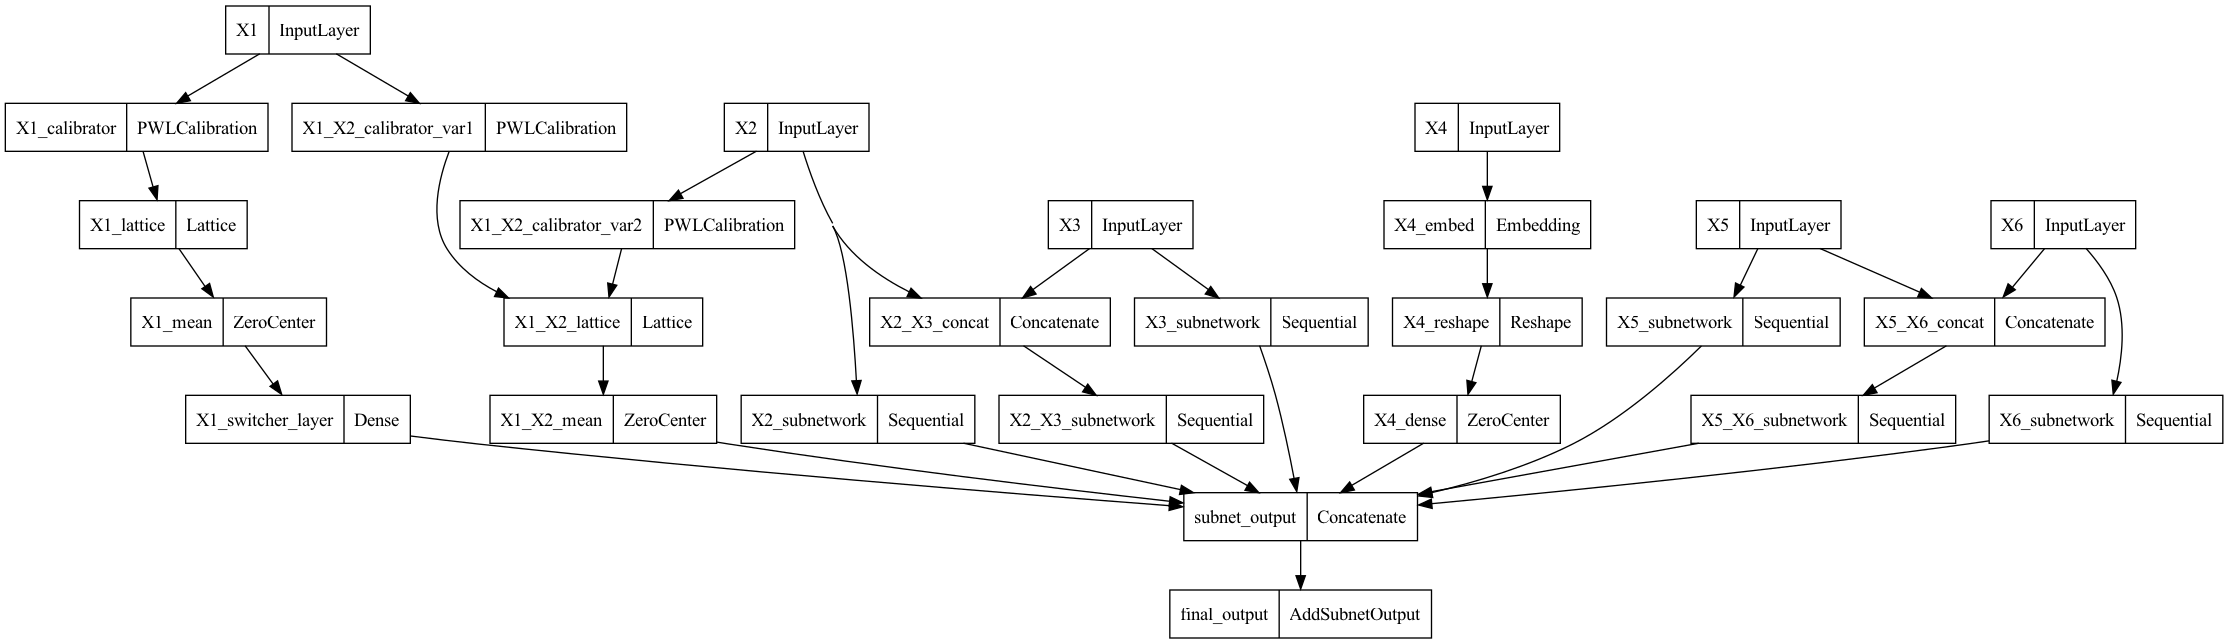

In [670]:
plot_model(model_main_pairwise)

In [671]:
# -------------------------- compile and fit --------------------------
# remove irrelevant main effects
X_train_important = []
X_val_important = []
X_test_important = []
for i in range(len(X_train_split)):
    if all_vars[i] in imp_vars:
        X_train_important.append(X_train_split[i])
        X_val_important.append(X_val_split[i])
        X_test_important.append(X_test_split[i])

model_main_pairwise.compile(optimizer = RMSprop(), loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main_pairwise = model_main_pairwise.fit(X_train_important, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_important, y_val))

Epoch 1/5000
12/12 [==============================] - 2s 30ms/step - loss: 727.5412 - root_mean_squared_error: 2636.7378 - val_loss: 728.7116 - val_root_mean_squared_error: 2535.9634
Epoch 2/5000
12/12 [==============================] - 0s 7ms/step - loss: 691.8277 - root_mean_squared_error: 2636.7043 - val_loss: 695.4333 - val_root_mean_squared_error: 2535.9229
Epoch 3/5000
12/12 [==============================] - 0s 7ms/step - loss: 658.6438 - root_mean_squared_error: 2636.6611 - val_loss: 660.4578 - val_root_mean_squared_error: 2535.8770
Epoch 4/5000
12/12 [==============================] - 0s 8ms/step - loss: 621.2644 - root_mean_squared_error: 2636.6074 - val_loss: 619.1336 - val_root_mean_squared_error: 2535.8059
Epoch 5/5000
12/12 [==============================] - 0s 7ms/step - loss: 586.7611 - root_mean_squared_error: 2636.5400 - val_loss: 592.3740 - val_root_mean_squared_error: 2535.7244
Epoch 6/5000
12/12 [==============================] - 0s 7ms/step - loss: 548.2940 - root

1/1 [==============================] - 0s 206ms/step


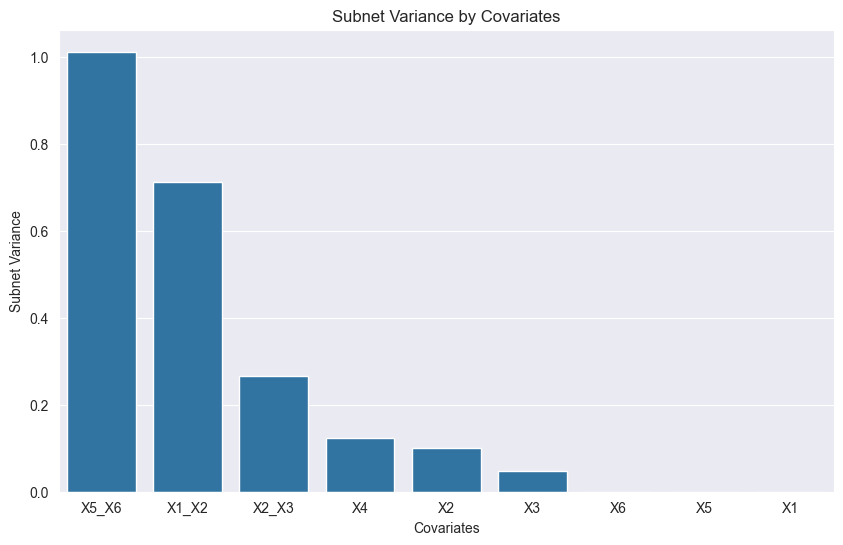

In [672]:
# -------------------------- quantify variable importance --------------------------
subnet_layer = model_main_pairwise.get_layer("subnet_output")
subnet_output_model = Model(inputs = model_main_pairwise.inputs, 
                            outputs = subnet_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_important, batch_size = X_train_important[0].shape[0])


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i]))

# Define covariates
covariates = [name for name in imp_vars]
for i in range(len(imp_interactions)):
    covariates.append(f"{imp_interactions[i][0]}_{imp_interactions[i][1]}")


# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

1/1 [==============================] - 0s 209ms/step


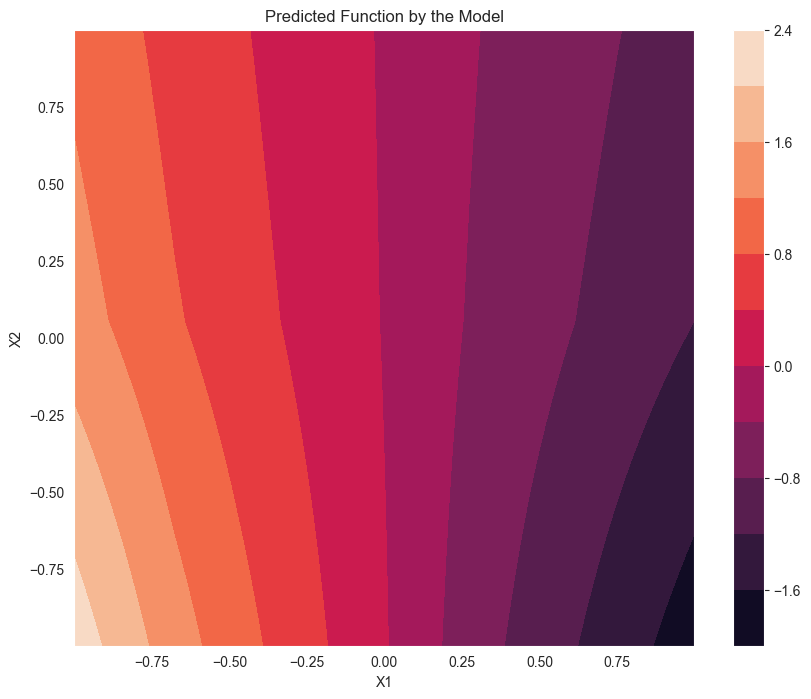

In [673]:
# -------------------------- Create the Pairwise Only Model --------------------------
pairwise_effect = ("X1","X2")  # the pairwise effect we want to view
pairwise_index = imp_interactions.index(pairwise_effect)
subnet_output_layer = model_main_pairwise.get_layer("subnet_output")
subnet_model = Model(inputs = model_main_pairwise.inputs, outputs = subnet_output_layer.output)


# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train[imp_interactions[pairwise_index][0]].min(), 
                          X_train[imp_interactions[pairwise_index][0]].max(), 
                          grid_length)
var2_values = np.linspace(X_train[imp_interactions[pairwise_index][1]].min(), 
                          X_train[imp_interactions[pairwise_index][1]].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in imp_vars:
    if var == imp_interactions[pairwise_index][0]:
        grid_inputs.append(grid_flat_var1)
    elif var == imp_interactions[pairwise_index][1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = subnet_model.predict(grid_inputs, batch_size = grid_length**2)[:,len(imp_vars) + pairwise_index]

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{imp_interactions[pairwise_index][0]}")
plt.ylabel(f"{imp_interactions[pairwise_index][1]}")
plt.show()

1/1 [==============================] - 0s 204ms/step


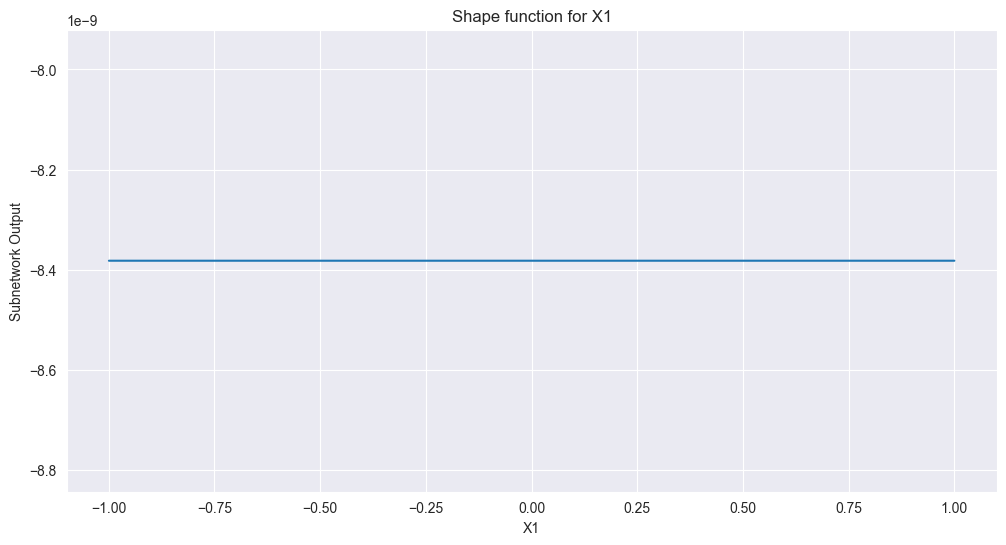

In [674]:
#-------------------------- view the shape function --------------------------
# get the prediction
subnet_output = subnet_model.predict(X_train_important, batch_size = X_train_important[0].shape[0])

# create the plot
var_name = "X1"
var_index = imp_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_important[var_index], 
             y = subnet_output[:,var_index])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()